<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Random Forest (RF) Modeling 
</p>

In [1]:
# Libraries for data manipulation and visualization
import numpy as np                               # For numerical operations
import pandas as pd                              # For data manipulation
import matplotlib.pyplot as plt                  # For plotting
import seaborn as sns                            # For advanced data visualization

# Libraries for model building and evaluation
from sklearn.ensemble import RandomForestRegressor  # For Random Forest Regression
from sklearn.metrics import (                   # For model evaluation metrics
    mean_squared_error, 
    r2_score, 
    mean_absolute_percentage_error, 
    median_absolute_error
)
from sklearn.model_selection import KFold, train_test_split  # For cross-validation and splitting data

# Set seed for reproducibility
np.random.seed(50)

In [2]:
# Define the path to the dataset
dataset_path = '../../all_data_files/cleaned_dataset_per_device.csv'

# Load the dataset
try:
    df = pd.read_csv(dataset_path)
    print("\nDataset loaded successfully.")
except FileNotFoundError:
    print(f"File not found at the specified path: {dataset_path}")
    import sys
    sys.exit()

# Display dataset information
print("\nDataset Information:")
df.info()
print("\nFirst Five Rows of the Dataset:")
display(df.head())


Dataset loaded successfully.

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607907 entries, 0 to 607906
Data columns (total 20 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   time         607907 non-null  object 
 1   device_id    607907 non-null  object 
 2   co2          607907 non-null  float64
 3   humidity     607907 non-null  float64
 4   pm25         607907 non-null  float64
 5   pressure     607907 non-null  float64
 6   temperature  607907 non-null  float64
 7   rssi         607907 non-null  float64
 8   snr          607907 non-null  float64
 9   SF           607907 non-null  int64  
 10  frequency    607907 non-null  float64
 11  f_count      607907 non-null  float64
 12  p_count      607907 non-null  float64
 13  toa          607907 non-null  float64
 14  distance     607907 non-null  int64  
 15  c_walls      607907 non-null  int64  
 16  w_walls      607907 non-null  int64  
 17  exp_pl       60

,time,device_id,co2,humidity,pm25,pressure,temperature,rssi,snr,SF,frequency,f_count,p_count,toa,distance,c_walls,w_walls,exp_pl,n_power,esp
0,2024-09-26 11:02:08.387851+00:00,ED0,539.0,49.34,0.39,299.69,24.57,-48.0,8.5,9,867.5,82.0,109.0,0.246784,10,0,0,65.4,-57.073822,-48.573822
1,2024-09-26 11:03:08.309590+00:00,ED0,540.0,49.33,0.80,299.77,24.59,-48.0,12.8,8,867.3,83.0,110.0,0.133632,10,0,0,65.4,-61.022142,-48.222142
2,2024-09-26 11:04:08.368448+00:00,ED0,537.0,49.28,0.71,299.70,24.62,-48.0,8.0,8,868.5,84.0,111.0,0.133632,10,0,0,65.4,-56.638920,-48.638920
3,2024-09-26 11:05:08.405529+00:00,ED0,537.0,49.34,0.56,299.69,24.63,-49.0,11.0,8,867.9,85.0,112.0,0.133632,10,0,0,66.4,-60.331956,-49.331956
4,2024-09-26 11:06:08.455112+00:00,ED0,534.0,49.28,0.60,299.73,24.64,-46.0,9.2,8,867.5,86.0,113.0,0.133632,10,0,0,63.4,-55.693058,-46.493058


In [3]:
# Define feature columns and target
feature_columns = [
    'distance', 'frequency', 'c_walls', 'w_walls', 
    'co2', 'humidity', 'pm25', 'pressure', 
    'temperature', 'snr'
]
target_column = 'exp_pl'

# Verify that all required columns exist
missing_columns = set(feature_columns + [target_column]) - set(df.columns)
if missing_columns:
    raise ValueError(f"The following required columns are missing in the dataset: {missing_columns}")

# Extract features and target
all_features = df[feature_columns].values
PL_all = df[target_column].values

# Perform train-test split (80-20 split)
X_train_all, X_test_all, PL_train_all, PL_test_all = train_test_split(
    all_features, PL_all, test_size=0.2, random_state=50
)

print("\nTrain-test split completed.\n")


Train-test split completed.



In [4]:
# Define Random Forest model
def create_rf_model():
    """Creates a Random Forest model with OOB enabled."""
    return RandomForestRegressor(
        n_estimators=200,  
        criterion='squared_error',
        max_depth=3,      
        max_features='log2',
        random_state=50,  
        n_jobs=-1,       
        min_samples_split=10, 
        min_samples_leaf=5, 
        min_impurity_decrease=0.001,
        bootstrap=True,      
        oob_score=True 
    )

# Instantiate the model
rf_model = create_rf_model()

# Train the model
print("\nTraining Random Forest model...")
rf_model.fit(X_train_all, PL_train_all)
print("\nTraining Completed! \n")

# Retrieve OOB score
oob_score = rf_model.oob_score_
print(f"Random Forest model training completed with OOB Score: {oob_score:.4f} \n")


Training Random Forest model...

Training Completed! 

Random Forest model training completed with OOB Score: 0.8485 



In [5]:
# Evaluate the model on training and test data
PL_train_pred = rf_model.predict(X_train_all)
PL_test_pred = rf_model.predict(X_test_all)

# Calculate metrics
train_mse = mean_squared_error(PL_train_all, PL_train_pred)
test_mse = mean_squared_error(PL_test_all, PL_test_pred)
train_r2 = r2_score(PL_train_all, PL_train_pred)
test_r2 = r2_score(PL_test_all, PL_test_pred)
test_rmse = np.sqrt(test_mse)
test_mape = mean_absolute_percentage_error(PL_test_all, PL_test_pred)
test_median_ae = median_absolute_error(PL_test_all, PL_test_pred)

# Create a results DataFrame
results = pd.DataFrame({
    'Metric': ['Training Loss (MSE)', 'Test Loss (MSE)', 'Test RMSE', 'R² Score', 
               'Test MAPE (%)', 'Test Median AE'],
    'Value': [train_mse, test_mse, test_rmse, test_r2, test_mape * 100, test_median_ae]
})

print("\nModel Evaluation Metrics:")
display(results)


Model Evaluation Metrics:


,Metric,Value
0,Training Loss (MSE),54.446857
1,Test Loss (MSE),54.078465
2,Test RMSE,7.353806
3,R² Score,0.850978
4,Test MAPE (%),6.166487
5,Test Median AE,4.528466


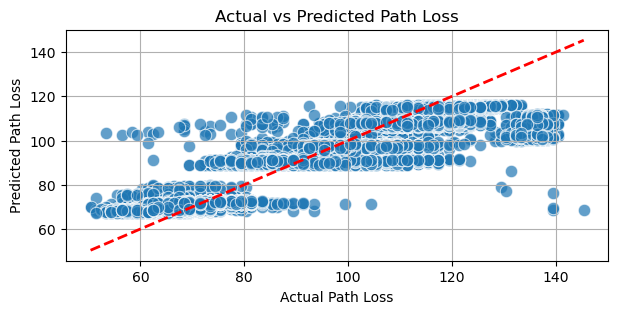

In [6]:
# Scatter plot of actual vs predicted values
plt.figure(figsize=(7, 3))
sns.scatterplot(x=PL_test_all, y=PL_test_pred, alpha=0.7, edgecolor='w', s=80)
plt.plot([PL_test_all.min(), PL_test_all.max()], [PL_test_all.min(), PL_test_all.max()], 'r--', lw=2)
plt.xlabel('Actual Path Loss')
plt.ylabel('Predicted Path Loss')
plt.title('Actual vs Predicted Path Loss')
plt.grid(True)
plt.show()

In [7]:
# Cell 7: Perform K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []
fold = 1

for train_idx, val_idx in kf.split(X_train_all):
    print(f"\nTraining fold {fold}...")

    # Split the data for the current fold
    X_train_fold, X_val_fold = X_train_all[train_idx], X_train_all[val_idx]
    PL_train_fold, PL_val_fold = PL_train_all[train_idx], PL_train_all[val_idx]

    # Create and train a new Random Forest model
    rf_model_cv = create_rf_model()
    rf_model_cv.fit(X_train_fold, PL_train_fold)

    # Predict and evaluate on validation set
    PL_val_pred = rf_model_cv.predict(X_val_fold)
    val_mse = mean_squared_error(PL_val_fold, PL_val_pred)
    val_rmse = np.sqrt(val_mse)
    val_r2 = r2_score(PL_val_fold, PL_val_pred)
    val_mape = mean_absolute_percentage_error(PL_val_fold, PL_val_pred)
    val_median_ae = median_absolute_error(PL_val_fold, PL_val_pred)

    # Append metrics
    cv_results.append({
        'Fold': fold,
        'Validation Loss (MSE)': round(val_mse, 4),
        'Validation RMSE': round(val_rmse, 4),
        'R² Score': round(val_r2, 4),
        'Validation MAPE (%)': round(val_mape * 100, 2),
        'Validation Median AE': round(val_median_ae, 4)
    })

    print(f"Fold {fold} - MSE: {val_mse:.4f}, RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}, MAPE: {val_mape*100:.2f}%, Median AE: {val_median_ae:.4f}")
    fold += 1

# Create a DataFrame from CV results
cv_results_df = pd.DataFrame(cv_results)

# Display cross-validation results
print("\nK-Fold Cross-Validation Results:")
display(cv_results_df)

# Summary statistics
cv_summary = cv_results_df.agg(['mean', 'std']).round(4).reset_index()
cv_summary.rename(columns={'index': 'Metric'}, inplace=True)

# Transposing the summary
cv_summary_transposed = cv_summary.set_index('Metric').T

print("\nCross-Validation Summary:")
display(cv_summary_transposed)


Training fold 1...
Fold 1 - MSE: 54.6762, RMSE: 7.3943, R²: 0.8482, MAPE: 6.18%, Median AE: 4.5273

Training fold 2...
Fold 2 - MSE: 54.4337, RMSE: 7.3779, R²: 0.8497, MAPE: 6.13%, Median AE: 4.5063

Training fold 3...
Fold 3 - MSE: 54.9232, RMSE: 7.4110, R²: 0.8490, MAPE: 6.18%, Median AE: 4.5192

Training fold 4...
Fold 4 - MSE: 53.9426, RMSE: 7.3446, R²: 0.8508, MAPE: 6.18%, Median AE: 4.5804

Training fold 5...
Fold 5 - MSE: 54.6283, RMSE: 7.3911, R²: 0.8498, MAPE: 6.17%, Median AE: 4.5541

K-Fold Cross-Validation Results:


,Fold,Validation Loss (MSE),Validation RMSE,R² Score,Validation MAPE (%),Validation Median AE
0,1,54.6762,7.3943,0.8482,6.18,4.5273
1,2,54.4337,7.3779,0.8497,6.13,4.5063
2,3,54.9232,7.4110,0.8490,6.18,4.5192
3,4,53.9426,7.3446,0.8508,6.18,4.5804
4,5,54.6283,7.3911,0.8498,6.17,4.5541



Cross-Validation Summary:


Metric,mean,std
Fold,3.0000,1.5811
Validation Loss (MSE),54.5208,0.3673
Validation RMSE,7.3838,0.0249
R² Score,0.8495,0.0010
Validation MAPE (%),6.1680,0.0217
Validation Median AE,4.5375,0.0297
